<a href="https://colab.research.google.com/github/NicolasPCS/Image-Classification/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot

import os
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback

from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

download_dir = Path('/content/drive/MyDrive/Tesis/New_Images_Dataset')

train_data_dir = download_dir/'training_set'
test_data_dir =download_dir/'validation_set'

class_subset = sorted(os.listdir(download_dir/'training_set'))[:16] # Using only the first 10 classes
#class_subset = len(os.listdir(test_data_dir))

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(299, 299),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 5590 images belonging to 16 classes.
Found 978 images belonging to 16 classes.
Found 2487 images belonging to 16 classes.


In [ ]:
#base_model = Xception(weights='imagenet', include_top=True)

#base_model.summary()

In [3]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = Xception(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)  # Número de unidades ajustado
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [4]:
input_shape = (299, 299, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=16

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 20

# First we'll train the model without Fine-tuning
xception_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
xception_model.summary()

In [5]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

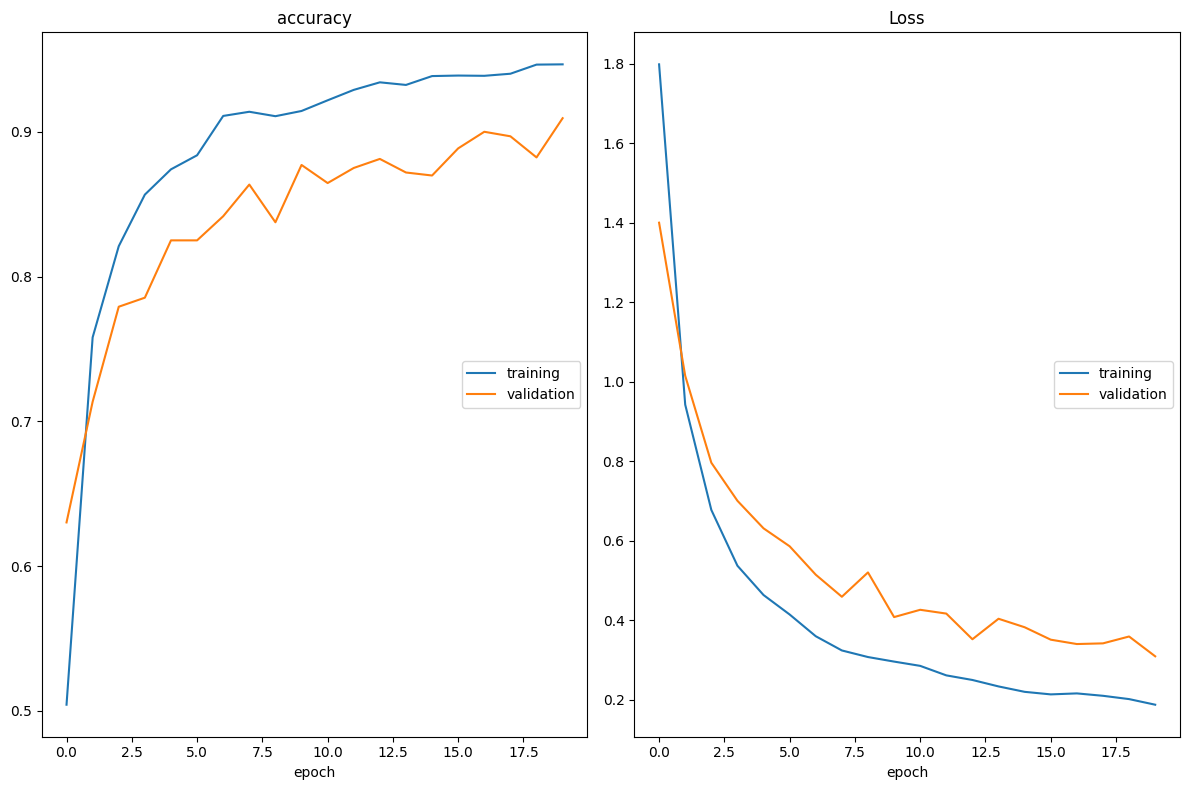

accuracy
	training         	 (min:    0.504, max:    0.947, cur:    0.947)
	validation       	 (min:    0.630, max:    0.909, cur:    0.909)
Loss
	training         	 (min:    0.187, max:    1.798, cur:    0.187)
	validation       	 (min:    0.309, max:    1.400, cur:    0.309)
174/174 [==============================] - 221s 1s/step - loss: 0.1871 - accuracy: 0.9466 - val_loss: 0.3088 - val_accuracy: 0.9094
CPU times: user 1h 8min 40s, sys: 3min 13s, total: 1h 11min 53s
Wall time: 1h 57min 22s


In [6]:
%%time

xception_history = xception_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [7]:
# Generate predictions
xception_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

xception_preds = xception_model.predict(testgen)
xception_pred_classes = np.argmax(xception_preds, axis=1)

2487/2487 [==============================] - 938s 377ms/step


In [8]:
from sklearn.metrics import accuracy_score

xception_acc = accuracy_score(true_classes, xception_pred_classes)
print("xception Model Accuracy without Fine-Tuning: {:.2f}%".format(xception_acc * 100))

xception Model Accuracy without Fine-Tuning: 69.80%


In [9]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
xception_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

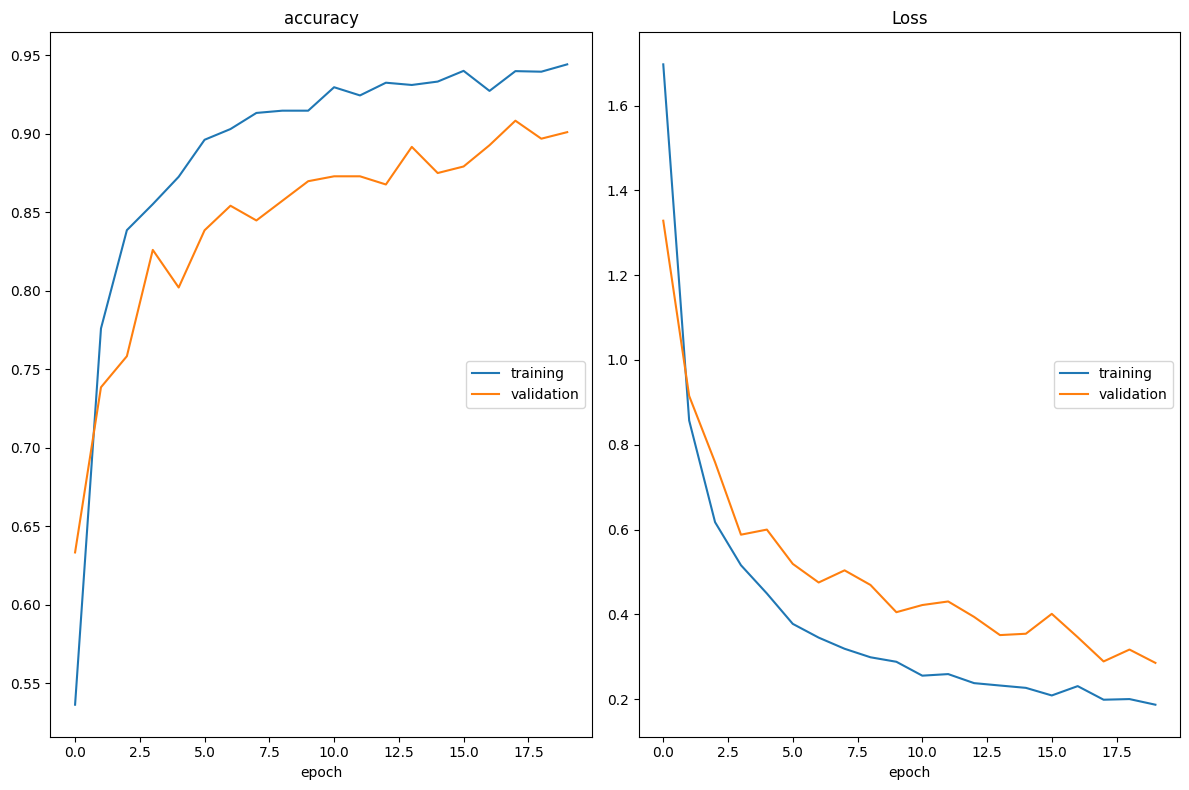

accuracy
	training         	 (min:    0.536, max:    0.944, cur:    0.944)
	validation       	 (min:    0.633, max:    0.908, cur:    0.901)
Loss
	training         	 (min:    0.187, max:    1.697, cur:    0.187)
	validation       	 (min:    0.286, max:    1.328, cur:    0.286)
174/174 [==============================] - 221s 1s/step - loss: 0.1870 - accuracy: 0.9442 - val_loss: 0.2857 - val_accuracy: 0.9010
CPU times: user 1h 8min 19s, sys: 3min 25s, total: 1h 11min 45s
Wall time: 1h 18min 20s


In [10]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
xception_ft_history = xception_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [11]:
# Generate predictions
xception_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

xception_preds_ft = xception_model_ft.predict(testgen)
xception_pred_classes_ft = np.argmax(xception_preds_ft, axis=1)

2487/2487 [==============================] - 29s 11ms/step


In [12]:
xception_acc_ft = accuracy_score(true_classes, xception_pred_classes_ft)
print("xception Model Accuracy with Fine-Tuning: {:.2f}%".format(xception_acc_ft * 100))

xception Model Accuracy with Fine-Tuning: 68.28%


In [ ]:
from keras.preprocessing import image
import numpy as np

# Ruta de la imagen que deseas predecir
image_path = '/content/drive/MyDrive/Tesis/New_Images_Dataset/training_set/billete10_reverso_nuevo/train_rev_10_nuevo_003.jpg'
image_path2 = '/content/drive/MyDrive/Tesis/New_Images_Dataset/training_set/billete20_reverso_nuevo/train_rev_20_nuevo_001.jpg'
image_path3 = '/content/drive/MyDrive/Tesis/New_Images_Dataset/training_set/billete50_reverso_nuevo/train_rev_50_nuevo_003.jpg'
image_path4 = '/content/drive/MyDrive/Tesis/New_Images_Dataset/validation_set/billete100_anverso_nuevo/val_anv_100_nuevo_03.jpg'

# Cargar la imagen y aplicar las mismas transformaciones que en el conjunto de prueba
img = image.load_img(image_path4, target_size=(224, 224))  # Ajusta el tamaño según tu modelo
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Agrega una dimensión de lote (batch) ya que el modelo espera lotes

# Realizar la predicción
xception_preds_single = xception_model.predict(img)

# Obtener la clase predicha (índice)
predicted_class_index = np.argmax(xception_preds_single, axis=1)

# Mapear el índice de clase a la etiqueta de clase
class_indices = traingen.class_indices
class_labels = list(class_indices.keys())
predicted_class_label = class_labels[predicted_class_index[0]]

print("Clase predicha:", predicted_class_label)

1/1 [==============================] - 0s 480ms/step
Clase predicha: billete20_anverso_antiguo
